# Retroalimentación Módulo 2
Leonardo Cossío Dinorín A01753898

Implementación de un modelo de Deep Learning

# Introducción:
Este proyecto busca implementar un **traductor de lenguaje de señas mexicano** en tiempo real utilizando Deep Learning.

La comunicación entre personas oyentes y personas sordas suele enfrentar una barrera cuando no existe un conocimiento mutuo del lenguaje de señas, limitando la accesibilidad y la inclusión en diversos entornos.

Para resolver este problema se implementó una red neuronal recurrente basada en LSTM. Este proyecto pretende reconocer gestos específicos y traducirlos a texto, brindando una herramienta que facilite la comunicación y contribuya a la inclusión de personas con discapacidad auditiva.

# Instalación de librerías

La parte más importante de este proyecto es **Mediapipe** porque proporciona herramientas avanzadas para el reconocimiento y seguimiento de gestos y poses, lo cual es esencial en un traductor de lenguaje de señas.

Para la primera iteración de este proyecto, se planteó utilizar una red neuronal convolucional junto con un conjunto de datos obtenido de Roboflow. Sin embargo, surgió un desafío importante: el lenguaje de señas mexicano incluye no solo formas estáticas de las manos, sino también gestos y movimientos específicos que requieren una comprensión de la secuencia temporal de cada seña.

Dado que una sola imagen no captura el movimiento ni el cambio de posición necesarios para interpretar correctamente una seña, la red CNN no fue suficiente para cumplir con los requisitos del proyecto. Esto motivó un cambio en el enfoque, hacia el uso de redes neuronales recurrentes y arquitecturas como LSTM, que pueden procesar secuencias temporales y detectar patrones en movimientos, siendo una opción mucho más adecuada para traducir señas en tiempo real.

In [4]:
%pip install mediapipe

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/50.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/50.9 MB 991.0 kB/s eta 0:00:52
   ---------------------------------------- 0.1/50.9 MB 2.1 MB/s eta 0:00:25
   ---------------------------------------- 0.3/50.9 MB 2.7 MB/s eta 0:00:19
   ---------------------------------------- 0.5/50.9 MB 3.6 MB/s eta 0:00:15
    --------------------------------------- 0.8/50.9 MB 4.1 MB/s eta 0:00:13
    --------------------------------------- 1.1/50.9 MB 4.9 MB/s eta 0:00:11
   - -------------------------------------- 1.5/50.9 MB 5.8 MB/s eta 0:00:09
   - -------------------------------------- 2.1/50.9 MB 6.5 MB/s eta 0:00:08
   - -------------------------------------- 2.5/50.9 MB 6.9 MB/s eta 0:00:07
   -- ------------------------------------- 2.9/50.9 MB 7.1 MB/s eta 0:00:07
   -- ------------------------------------- 3.5/50.9 MB 7.7 MB/s eta 0:00:07
   --- --------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.5.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importación de librerías

Además de **Mediapipe**, se utilizaron librerías como:

**OpenCV:** Para facilitar la implementación del modelo y hacer un programa que lo traduzca en tiempo real.

**Numpy:** Para el manejo de arreglos y matrices.

**Os:** Para la gestión de archivos.

**Matplotlib:** Utilizando pyplot , nos permite crear gráficos de desempeño y ejemplos visuales de las señas capturadas.

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from sklearn.metrics import confusion_matrix
from scipy import stats

# Modelo holístico de Mediapipe

Este modelo sirve para detectar y rastrear elementos clave del cuerpo humano, como lo son las manos, el rostro y la pose de manera simultánea. Este modelo nos va a servir para dos cosas:

1) La creación de un dataset personalizado.

2) La implementación del modelo en tiempo real.

In [2]:
# Asignación del modelo holístico
mp_holistic = mp.solutions.holistic

# Dibujar puntos clave y conexiones
mp_drawing = mp.solutions.drawing_utils

In [3]:
# Esta función se encarga de procesar una imagen con el modelo de MediaPipe para detectar 
# puntos clave, posteriormente devuelve la imagen procesada y los resultados de la detección.
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
# Esta función dibuja los puntos clave y las conexiones de los diferentes segmentos
# del cuerpo en una imagen procesada utilizando los resultados del modelo.
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
# Esta función da un estilo personalizado a las conexiones detectadas.
def draw_styled_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0,255,0), thickness=1, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(0,128,0), thickness=1, circle_radius=1)
                            )

    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,0,0), thickness=1, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(128,0,0), thickness=1, circle_radius=1)
                             ) 

    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=1, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(0,0,128), thickness=1, circle_radius=1)
                             ) 

### Prueba de modelo Mediapipe

A continuación se hace una pequeña prueba del modelo holístico, este programa utiliza la cámara de la computadora como input y detecta los puntos clave del cuerpo de la persona dentro del frame.

In [ ]:
# Confianza mínima de la detección
detection_confidence = 0.6
# Confianza mínima del seguimiento de los puntos clave
tracking_confidence = 0.6

cap = cv2.VideoCapture(0) # Abrir la cámara

# Redimensionar el frame para que la detección sea más rápida
# Esta parte del código es debido a las limitaciones de hardware
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)

# Detección de los puntos clave
with mp_holistic.Holistic(min_detection_confidence=detection_confidence, min_tracking_confidence=tracking_confidence) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic) # Detectar puntos clave

        draw_styled_landmarks(image, results) # Dibujar puntos clave 

        cv2.imshow("Holistic model", image) # Mostrar el resultado

        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
    cap.release()
    cv2.destroyAllWindows()

### Extracción de puntos clave

El modelo holístico de mediapipe devuelve sus detecciones como NamedTuple, sin embargo, necesitamos convertir esos resultados a un arreglo de Numpy para posteriormente poder entrenar al modelo.

In [6]:
# Esta función se encarga de extraer los puntos clave de la mano derecha e izquierda
# para posteriormente convertirlos en un arreglo de Numpy
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [35]:
result_test = extract_keypoints(results)

In [38]:
result_test

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

# Creación del dataset

Para resolver este problema, se decidió crear un dataset propio, esto debido principalmente al formato en el que se necesitan los datos para alimentar al modelo.

Como se comentó anteriormente, la idea original de este proyecto era descargar un dataset de internet, sin embargo, los datasets encontrados tenían 2 problemas:

1) Eran imágenes etiquetadas, pensando en hacer una red neuronal convolucional.
2) Los datasets de mayor calidad (Cantidad de imágenes y etiquetado) eran para la lengua de señas americana o india, sin embargo, no había mucho para la lengua de señas mexicana.

Se decidió crear un pequeño dataset con 4 clases (palabras básicas), las cuales son: Hola, Sí, No y Gracias.

**Para la primera iteración del modelo se grabaron 30 secuencias por clase.**

**Para la segunda iteración (Modelo mejorado) se grabaron 90 secuencias por clase.**

-----------------------------------------------------------------------------

**Guía de lenguaje de señas para el problema:**

- Hola: https://youtu.be/PCHx3s-cwLU?si=w4Kda9KQxX5IWxxq

- Sí / No: https://youtu.be/cqEL5lYCL2s?si=q7yg9IXhXXuGa98-

- Gracias: https://youtu.be/xEqJFJGIplE?si=_PHP2RXsVzBsG92r

In [7]:
DATA_PATH = os.path.join('Data') # Carpeta para almacenar el dataset

actions = np.array(['hola', 'si', 'no', 'gracias']) # Clases

no_sequences = 30 # Número de secuencias para recolectar 

sequence_length = 30 # Duración de las secuencias (En frames)

start_folder = 60 # Número de secuencia a almacenar

### Programa de recolección de datos
Este programa utiliza OpenCV para grabar pequeños videos de 30 frames, donde se utiliza el modelo holístico para detectar los puntos clave y guardar las secuencias (En formato .npy) en la carpeta "Data" y en la carpeta de cada clase.

En la imagen proporcionada por la cámara se mostrará un texto diciendo de qué palabra se está creando el dataset y el número de secuencia que se está grabando, el programa estará en ejecución hasta que se graben 30 secuencias de cada palabra.

In [ ]:
cap = cv2.VideoCapture(0) # Abrir la cámara

# Redimensionar el frame
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)

# Comenzar la detección y recolección de datos
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Iterar sobre cada palabra
    for action in actions:
        # Itera sobre cada secuencia de frames
        for sequence in range(start_folder, start_folder+no_sequences):
            # Itera sobre cada frame
            for frame_num in range(sequence_length):

                ret, frame = cap.read() # Leer captura

                image, results = mediapipe_detection(frame, holistic) # Detección

                draw_styled_landmarks(image, results) # Dibujar puntos clave
                # Cuando comienza cada secuencia, muestra un mensaje de "STARTING COLLECTION"
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Palabra: {} Video: {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)
                    # Se le da al usuario una pequeña pausa para prepararse al inicio de cada secuencia
                    cv2.imshow('Holistic model', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Palabra: {} Video: {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)

                    cv2.imshow('Holistic model', image)
                
                # Se extraen los puntos clave y se convierten a formato numpy
                keypoints = extract_keypoints(results)
                # Se guarda la secuencia con el número de secuencia en la carpeta correspondiente
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                os.makedirs(os.path.dirname(npy_path), exist_ok=True)
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

Se codifican las clases existentes y se guardan en un diccionario.

In [8]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hola': 0, 'si': 1, 'no': 2, 'gracias': 3}

El siguiente fragmento de código prepara y organiza los datos (Separa y organiza las secuencias y su respectiva etiqueta).

In [12]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

Se crea el dataset y las etiquetas (X y Y).

In [13]:
np.array(sequences).shape

(356, 30, 126)

In [14]:
X = np.array(sequences)

In [15]:
X.shape

(356, 30, 126)

In [16]:
y = to_categorical(labels).astype(int)

### Separación del dataset

Se separa el set de entrenamiento y el de validación. Como son muy pocos datos, el set de entrenamiento tendrá 360 secuencias de entrenamiento (90% del dataset) y 36 de validación (10% del dataset).

In [17]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2)

In [18]:
y_test.shape

(36, 4)

In [19]:
y_train.shape

(256, 4)

In [20]:
y_val.shape

(64, 4)

# Creación del modelo con LSTM (Primera iteración)

Para esta primera iteración se utilizó un primer dataset con 120 secuencias, de las cuales se destinaron 95% para el entrenamiento y 5% para la prueba, esto debido al tamaño tan reducido del dataset, ni siquiera se pudo implementar un set de validación, sin embargo, para la segunda iteración se corregirá este error.

In [10]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

Este problema se resuelve implementando un modelo secuencial que contiene **capas LSTM** (Long Short Term Memory) con función de activación ReLU, las cuales son cruciales porque permiten capturar dependencias en el tiempo, una característica fundamental para el reconocimiento de lenguaje de señas, ya que los gestos son secuencias de posiciones y movimientos que tienen una estructura temporal. Posteriormente se implementan 3 capas densas, las cuales sirven para consolidar la información y producir una salida categórica.


In [ ]:
model = Sequential()
# Capas LSTM
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126))) # Capa de input: 30 frames con 126 características
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) # En esta capa se reduce la dimensionalidad de la salida para las capas densas
# Capas densas
model.add(Dense(64, activation='relu')) # Capa de ajuste
model.add(Dense(32, activation='relu')) # Capa de ajuste
model.add(Dense(actions.shape[0], activation='softmax')) # Distribución de probabilidad para las diferentes clases

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) # Optimizador y métricas

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback]) # Entrenamiento de 2000 épocas

Epoch 1/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - categorical_accuracy: 0.4570 - loss: 1.3654
Epoch 2/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.4505 - loss: 1.1387
Epoch 3/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.4598 - loss: 1.5943
Epoch 4/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.4686 - loss: 1.2185
Epoch 5/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.4693 - loss: 0.9324
Epoch 6/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.5433 - loss: 0.8366
Epoch 7/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.6961 - loss: 0.7323
Epoch 8/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.7736 - loss: 0.6972
Epoch 9/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.7368 - loss: 1.1863
Epoch 10/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.7611 - loss: 1.5868
Epoch 11/2000
4/4 ━━━━━━━━━━━

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,478 (2.33 MB)

 Trainable params: 203,492 (794.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 406,986 (1.55 MB)

### Resultados del primer modelo

In [ ]:
res = model.predict(X_test) # Predicciones del conjunto de prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


In [ ]:
actions[np.argmax(res[4])] # Predicción del valor 4

'no'

In [ ]:
actions[np.argmax(y_test[4])] # Etiqueta verdadera del valor 4

'no'

In [ ]:
model.save('modelV1.h5') # Guardar el modelo

In [30]:
del model # Liberar memoria

In [11]:
model = load_model('modelV1.h5') # Cargar el modelo

In [ ]:
y_pred = model.predict(X_test) # Predicciones del set de prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
# Representar las predicciones y las etiquetas verdaderas en 
# valores enteros para facilitar la evaluación del modelo
ytrue = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

Para este modelo se obtuvo un 83% de accuracy, lo cual es aceptable tomando en cuenta la cantidad de datos recopilados.

NOTA: Se debe tomar en cuenta que el set de prueba representa solo el 5% del dataset completo, lo que significa que está evaluando al modelo con solo 6 secuencias, sin embargo, el desempeño del modelo será medido de mejor manera al momento de hacer detecciones en tiempo real.

In [75]:
accuracy_score(ytrue, y_pred)

0.8333333333333334

In [76]:
print(y_pred.shape)

(6,)


Se imprimió la matriz de confusión para ver el desempeño del modelo durante la fase de prueba.

Como se puede observar, el modelo se confundió al momento de predecir la etiqueta 0 ("Hola").
Sin embargo, estas confusiones son mucho más notorias al momento de probar las detecciones en tiempo real.

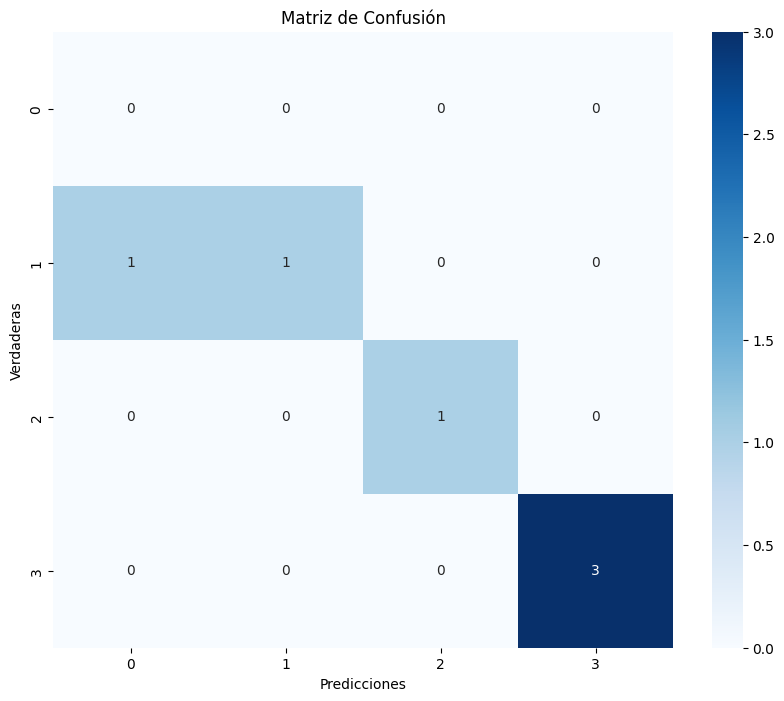

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(cm)), yticklabels=np.arange(len(cm)))
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderas')
plt.show()


# Modelo 2

Para la segunda iteración se optó por aumentar el tamaño del dataset y grabar 90 secuencias por palabra, lo que nos da una cantidad de 360 secuencias en total para entrenar al nuevo modelo.

El 90% del dataset fue destinado al entrenamiento (Con 20% del mismo para datos de validación) y el 10% a la validación.

In [31]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

También se optó por usar estrategias que os ayudaran a reducir el posible overfitting y sobretodo el tiempo de entrenamiento en caso de que el modelo ya no siguiera mejorando conforme avanzaran las épocas.

La métrica que tomará en cuenta el early stopping es el "val_categorical_accuracy" con una paciencia de 100. Se eligió esta métrica debido a que cuando se tomaba en cuenta el "val_loss" para el early stopping, el modelo terminaba con un accuracy muy bajo en el set de validación.

In [54]:
# Define el EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',   # Métrica a monitorear (generalmente 'val_loss' para evitar sobreajuste)
    patience=100,           # Número de épocas sin mejora para detener el entrenamiento
    restore_best_weights=True  # Restaura los pesos del modelo en su mejor época
)

Para esta segunda iteración, el modelo cambió bastante, aunque manteniendo una arquitectura similar.

Se realizaron los siguientes cambios:

1) Se utilizan **Bidirectional LSTMs**, las cuales nos permiten capturar los patrones tanto hacia adelante como hacia atrás.

2) Se agregó un **Dropout** a todas las capas intermedias, esto para evitar el overfitting.

3) Se añadió un **BatchNormalization** después de cada capa LSTM, esto ayuda a estabilizar y acelerar el entrenamiento ajustando dinámicamente la escala de las activaciones. Esto permite que el modelo aprenda más eficientemente, haciendo que el entrenamiento sea más estable y efectivo, especialmente en redes profundas.

4) Se cambió la **función de activación** de las LSTM a **tanh**, debido a que en la práctica es más utilizada en este tipo de capas debido a que ayuda a manejar datos secuenciales al mantener valores en un rango entre -1 y 1, lo cual previene problemas de explosión de gradientes y es más adecuada para secuencias temporales.

5) Se agregó la **regularización L2** a las capas densas para evitar el overfitting.

In [55]:
model = Sequential()
model.add(Input(shape=(30, 126))) # Capa de input
# Capas LSTM Bidireccional
model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(64, return_sequences=False, activation='tanh')))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Capas densas
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(actions.shape[0], activation='softmax')) # Output


Posteriormente se compila el modelo, se define su optimizador y su métrica.

In [56]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Este modelo se entrenó con 2500 épocas (500 más que el modelo anterior). Sin embargo, debido al early stopping, el modelo solamente entrenó durante 115 épocas y alcanzó un desempeño alto en el entrenamiento, con un "val_loss" del 0.15 y un accuracy de validación de 0.93, lo cual es una buena señal, sin embargo, el modelo será puedto a prueba con el set de test y la implementación en tiempo real.

In [57]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2500, callbacks=[tb_callback, early_stopping])

Epoch 1/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - categorical_accuracy: 0.4261 - loss: 2.8087 - val_categorical_accuracy: 0.4531 - val_loss: 2.5593
Epoch 2/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - categorical_accuracy: 0.7930 - loss: 1.7910 - val_categorical_accuracy: 0.5625 - val_loss: 2.4454
Epoch 3/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - categorical_accuracy: 0.8897 - loss: 1.6546 - val_categorical_accuracy: 0.5625 - val_loss: 2.3422
Epoch 4/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - categorical_accuracy: 0.9227 - loss: 1.4967 - val_categorical_accuracy: 0.5000 - val_loss: 2.2429
Epoch 5/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - categorical_accuracy: 0.9377 - loss: 1.4113 - val_categorical_accuracy: 0.5625 - val_loss: 2.1417
Epoch 6/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - categorical_accuracy: 0.9604 - loss: 1.3478 - val_categorical_accuracy: 0.5938 - val_loss: 1.9972
Epoch 7/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - categorical_accuracy: 0.9730 - loss: 1.

Se puede observar que el modelo se detuvo en la época 115 y mantiene un equilibrio entre la exactitud con los datos de prueba y los de entrenamiento, por lo que podemos concluir que el modelo tiene un buen desempeño, sin embargo, esto será puesto a prueba con los datos de prueba y la implementación del modelo en tiempo real.

In [58]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 30, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,611,438 (6.15 MB)

 Trainable params: 536,804 (2.05 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 1,073,610 (4.10 MB)

Una vez entrenado el modelo, se evaluó utilizando los datos de prueba (36 secuencias).

In [25]:
res = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Valor predicho para la secuencia 7:

In [32]:
actions[np.argmax(res[7])]

'hola'

Valor verdadero para la secuencia 7:

In [33]:
actions[np.argmax(y_test[7])]

'hola'

Guardar el modelo como .keras.

In [ ]:
model.save('modelV3.keras')

Liberar memoria

In [87]:
del model

In [10]:
model = load_model('modelV3.keras')

In [21]:
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 852ms/step


In [22]:
ytrue = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

Para las 36 secuencias dentro del set de validación se obtuvo una exactitud del 100%, lo que indica que el modelo no presenta un sobreajuste y logró capturar las características necesarias, sin embargo, todavía queda probar su desempeño con datos completamente nuevos y en tiempo real.

In [23]:
accuracy_score(ytrue, y_pred)

1.0

Como se puede observar en la matriz de confusión, el modelo trabaja perfecto con datos completamente nuevos obtenidos del conjunto de prueba.

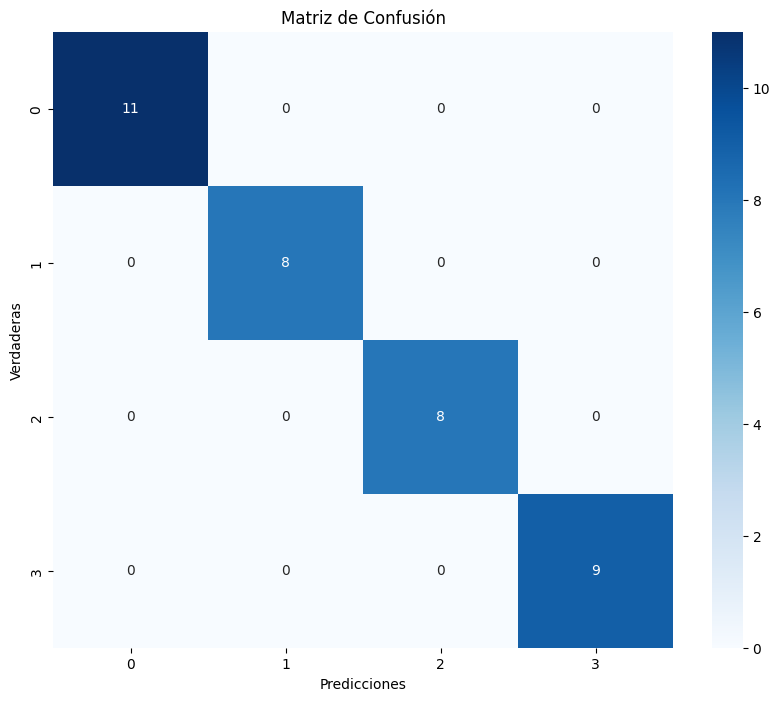

In [24]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(cm)), yticklabels=np.arange(len(cm)))
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderas')
plt.show()


# Prueba del modelo en tiempo real

Se diseñó un pequeño programa que utiliza la cámara de la computadora para subtitular el lenguaje de señas mexicano (Limitado a las 4 palabras del set de datos).

La inferencia se hace en tiempo real y en la parte inferior de la captura se puede leer la predicción del modelo.

In [36]:
sequence = []
predictions = []
threshold = 0.5 # Nivel de confianza 

cap = cv2.VideoCapture(0)
# Cargar el modelo holístico
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Leer el frame
        ret, frame = cap.read()

        # Detecciones del modelo holístico
        image, results = mediapipe_detection(frame, holistic)
        
        # Dibujar puntos clave
        draw_styled_landmarks(image, results)
        
        # Extraer puntos clave y convertirlos a formato de numpy
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

            # Solo se mostrará la predicción si se supera el nivel de confianza establecido
            if res[np.argmax(res)] > threshold:
                detected_class = actions[np.argmax(res)]
                
                # Mostrar el subtítulo
                cv2.rectangle(image, (0, image.shape[0] - 40), (640, image.shape[0]), (245, 117, 16), -1)
                cv2.putText(image, detected_class, (10, image.shape[0] - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Mostrar fotograma
        cv2.imshow('Inferencia', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()
            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

# Conclusión

Se logró implementar un modelo con capas LSTM capaz de detectar 4 palabras en Lengua de Señas Mexicana.

Para este proyecto, fue necesario investigar cómo integrar modelos ya existentes, como el modelo holístico de Mediapipe, con una red neuronal personalizada creada desde cero. Se realizaron procesos de evaluación y optimización para mejorar el rendimiento del modelo.

Inicialmente, se consideró abordar este problema mediante una red convolucional y transfer learning usando la arquitectura de YOLO. Sin embargo, esta aproximación resultó inadecuada, ya que la lengua de señas depende no solo de la posición de las manos, sino también de gestos que constituyen una secuencia temporal y no una imagen estática. Este desafío llevó a explorar nuevos métodos, como Mediapipe para la detección de manos y una red LSTM para capturar patrones temporales. Las LSTM fueron cruciales para el proyecto, ya que pueden almacenar datos en una memoria a corto plazo, lo que les permite detectar y procesar secuencias temporales.

El uso de un dataset propio dificultó la evaluación completa del modelo, pues, debido a la cantidad limitada de datos, es difícil saber con precisión si el modelo está haciendo overfitting. El tamaño reducido de los conjuntos de validación y prueba limita la variedad de escenarios evaluables, por lo que no es posible cubrir todos los posibles contextos.

Este trabajo representa una implementación básica de una solución que podría crecer considerablemente en complejidad, dado que la Lengua de Señas Mexicana incluye miles de palabras y gestos. Para avanzar en este campo, sería fundamental desarrollar un dataset amplio y variado que capture las distintas palabras y frases, así como las variaciones inherentes a cada gesto.